# CycleGAN


This project is about translating male faces to female and vice versa, using the generative adversarial networks structure, explained in details in the report.
This work is done under google colab.
So you need to import the data in your drive repository if you want to do so or change the paths.



By defaut colab uses the latest version of tensorflow but i'm working here with the old version so i need to specify that.

In [ ]:
 %tensorflow_version 1.x

TensorFlow 1.x selected.


Let's install some needed packages !

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install progress

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-8oju_9tt
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-8oju_9tt
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=08224bb1c403aaa1711dbf1b1a4edcb38f9f3838450e7a874842d5cb58f01d7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qrn04jgx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Created wheel for progress: filename=progress-1.5-cp36-none-any.whl size=8074 sha256=867c15546d017dc35b53e764f2c85bd45c7a8b54e385840fc494a1846f3ae464
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress


In [ ]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, \
    Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf
import os

Using TensorFlow backend.


To work with CUDA environement.

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Here are some helping functions we want to use later in our code :

In [ ]:
from keras.layers import Layer
from keras_contrib.layers.normalization.instancenormalization import InputSpec

import numpy as np
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import os

import keras.backend as K
import tensorflow as tf


class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')


class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            if len(image.shape) == 3:
                image = image[np.newaxis, :, :, :]

            if self.num_imgs < self.pool_size:  # fill up the image pool
                self.num_imgs = self.num_imgs + 1
                if len(self.images) == 0:
                    self.images = image
                else:
                    self.images = np.vstack((self.images, image))

                if len(return_images) == 0:
                    return_images = image
                else:
                    return_images = np.vstack((return_images, image))

            else:  # 50% chance that we replace an old synthetic image
                p = np.random.rand()
                if p > 0.5:
                    random_id = np.random.randint(0, self.pool_size)
                    tmp = self.images[random_id, :, :, :]
                    tmp = tmp[np.newaxis, :, :, :]
                    self.images[random_id, :, :, :] = image[0, :, :, :]
                    if len(return_images) == 0:
                        return_images = tmp
                    else:
                        return_images = np.vstack((return_images, tmp))
                else:
                    if len(return_images) == 0:
                        return_images = image
                    else:
                        return_images = np.vstack((return_images, image))

        return return_images


def load_data(subfolder='', generator=False):
    def create_image_array(image_list, image_path, image_size, nr_of_channels):
        bar = Bar('Loading...', max=len(image_list))

        # Define image array
        image_array = np.empty((len(image_list),) + (image_size) + (nr_of_channels,))
        i = 0
        for image_name in image_list:
            # If file is image...
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                # Load image and convert into np.array
                image = mpimg.imread(os.path.join(image_path, image_name))  # Normalized to [0,1]
                # image = np.array(Image.open(os.path.join(image_path, image_name)))

                # Add third dimension if image is 2D
                if nr_of_channels == 1:  # Gray scale image -> MR image
                    image = image[:, :, np.newaxis]

                # Normalize image with (max 8 bit value - 1)
                image = image * 2 - 1
                # image = image / 127.5 - 1

                # Add image to array
                image_array[i, :, :, :] = image
                i += 1
                bar.next()
        bar.finish()

        return image_array

    # Image paths
    trainA_path = os.path.join( subfolder, 'trainA')
    trainB_path = os.path.join(subfolder, 'trainB')
    testA_path = os.path.join(subfolder, 'testA')
    testB_path = os.path.join( subfolder, 'testB')

    # Image file names
    trainA_image_names = sorted(os.listdir(trainA_path))
    trainB_image_names = sorted(os.listdir(trainB_path))
    testA_image_names = sorted(os.listdir(testA_path))
    testB_image_names = sorted(os.listdir(testB_path))

    # Examine one image to get size and number of channels
    im_test = mpimg.imread(os.path.join(trainA_path, trainA_image_names[0]))
    # im_test = np.array(Image.open(os.path.join(trainA_path, trainA_image_names[0])))

    if len(im_test.shape) == 2:
        image_size = im_test.shape
        nr_of_channels = 1
    else:
        image_size = im_test.shape[0:-1]
        nr_of_channels = im_test.shape[-1]

    trainA_images = create_image_array(trainA_image_names, trainA_path, image_size, nr_of_channels)
    trainB_images = create_image_array(trainB_image_names, trainB_path, image_size, nr_of_channels)
    testA_images = create_image_array(testA_image_names, testA_path, image_size, nr_of_channels)
    testB_images = create_image_array(testB_image_names, testB_path, image_size, nr_of_channels)

    return {"image_size": image_size, "nr_of_channels": nr_of_channels,
            "trainA_images": trainA_images, "trainB_images": trainB_images,
            "testA_images": testA_images, "testB_images": testB_images,
            "trainA_image_names": trainA_image_names,
            "trainB_image_names": trainB_image_names,
            "testA_image_names": testA_image_names,
            "testB_image_names": testB_image_names}


def write_metadata_to_JSON(model, opt):
    # Save meta_data
    data = {}
    data['meta_data'] = []
    data['meta_data'].append({
        'img shape: height,width,channels': opt['img_shape'],
        'batch size': opt['batch_size'],
        'save training img interval': opt['save_training_img_interval'],
        'normalization function': str(model['normalization']),
        'lambda_ABA': opt['lambda_ABA'],
        'lambda_BAB': opt['lambda_BAB'],
        'lambda_adversarial': opt['lambda_adversarial'],
        'learning_rate_D': opt['learning_rate_D'],
        'learning rate G': opt['learning_rate_G'],
        'epochs': opt['epochs'],
        'use linear decay on learning rates': opt['use_linear_decay'],
        'epoch where learning rate linear decay is initialized (if use_linear_decay)': opt['decay_epoch'],
        'generator iterations': opt['generator_iterations'],
        'discriminator iterations': opt['discriminator_iterations'],
        'use patchGan in discriminator': opt['use_patchgan'],
        'beta 1': opt['beta_1'],
        'beta 2': opt['beta_2'],
        'REAL_LABEL': opt['REAL_LABEL'],
        'number of A train examples': len(opt['A_train']),
        'number of B train examples': len(opt['B_train']),
        'number of A test examples': len(opt['A_test']),
        'number of B test examples': len(opt['B_test']),
        'discriminator sigmoid': opt['discriminator_sigmoid'],
        'resize convolution': opt['use_resize_convolution'],
    })

    with open('{}/meta_data.json'.format(opt['out_dir']), 'w') as outfile:
        json.dump(data, outfile, sort_keys=True)


def write_loss_data_to_file(opt, history):
    keys = sorted(history.keys())
    with open('images/{}/loss_output.csv'.format(opt['date_time']), 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(keys)
        writer.writerows(zip(*[history[key] for key in keys]))


def join_and_save(opt, images, save_path):
    # Join images
    image = np.hstack(images)

    # Save images
    if opt['channels'] == 1:
        image = image[:, :, 0]

    mpimg.imsave(save_path, image, vmin=-1, vmax=1, cmap='gray')


def save_epoch_images(model, opt, epoch, num_saved_images=1):
    # Save training images
    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]

    rand_ind_A = np.random.randint(nr_train_im_A)
    rand_ind_B = np.random.randint(nr_train_im_B)

    real_image_A = opt['A_train'][rand_ind_A]
    real_image_B = opt['B_train'][rand_ind_B]
    synthetic_image_B = model['G_A2B'].predict(real_image_A[np.newaxis])[0]
    synthetic_image_A = model['G_B2A'].predict(real_image_B[np.newaxis])[0]
    reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
    reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

    save_path_A = '{}/train_A/epoch{}.png'.format(opt['out_dir'], epoch)
    save_path_B = '{}/train_B/epoch{}.png'.format(opt['out_dir'], epoch)
    if opt['paired_data']:
        real_image_Ab = opt['B_train'][rand_ind_A]
        real_image_Ba = opt['A_train'][rand_ind_B]
        join_and_save(opt, (real_image_Ab, real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_Ba, real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)
    else:
        join_and_save(opt, (real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)

    # Save test images
    real_image_A = opt['A_test'][0]
    real_image_B = opt['B_test'][0]
    synthetic_image_B = model['G_A2B'].predict(real_image_A[np.newaxis])[0]
    synthetic_image_A = model['G_B2A'].predict(real_image_B[np.newaxis])[0]
    reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
    reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

    save_path_A = '{}/test_A/epoch{}.png'.format(opt['out_dir'], epoch)
    save_path_B = '{}/test_B/epoch{}.png'.format(opt['out_dir'], epoch)
    if opt['paired_data']:
        real_image_Ab = opt['B_test'][0]
        real_image_Ba = opt['A_test'][0]
        join_and_save(opt, (real_image_Ab, real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_Ba, real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)
    else:
        join_and_save(opt, (real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)


def save_tmp_images(model, opt, real_image_A, real_image_B, synthetic_image_A, synthetic_image_B):
    try:
        reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
        reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

        real_images = np.vstack((real_image_A, real_image_B))
        synthetic_images = np.vstack((synthetic_image_B, synthetic_image_A))
        reconstructed_images = np.vstack((reconstructed_image_A, reconstructed_image_B))

        save_path = '{}/tmp.png'.format(opt['out_dir'])
        join_and_save(opt, (real_images, synthetic_images, reconstructed_images), save_path)
    except: # Ignore if file is open
        pass


def get_lr_linear_decay_rate(opt):
    # Calculate decay rates
    # max_nr_images = max(len(opt['A_train']), len(opt['B_train']))

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_batches_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']))

    updates_per_epoch_D = 2 * nr_batches_per_epoch
    updates_per_epoch_G = nr_batches_per_epoch
    nr_decay_updates_D = (opt['epochs'] - opt['decay_epoch'] + 1) * updates_per_epoch_D
    nr_decay_updates_G = (opt['epochs'] - opt['decay_epoch'] + 1) * updates_per_epoch_G
    decay_D = opt['learning_rate_D'] / nr_decay_updates_D
    decay_G = opt['learning_rate_G'] / nr_decay_updates_G

    return decay_D, decay_G


def update_lr(model, decay):
    new_lr = K.get_value(model.optimizer.lr) - decay
    if new_lr < 0:
        new_lr = 0
    # print(K.get_value(model.optimizer.lr))
    K.set_value(model.optimizer.lr, new_lr)


def print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index):
    passed_time = time.time() - start_time

    iterations_so_far = ((epoch - 1) * nr_im_per_epoch + loop_index) / opt['batch_size']
    iterations_total = opt['epochs'] * nr_im_per_epoch / opt['batch_size']
    iterations_left = iterations_total - iterations_so_far
    eta = round(passed_time / (iterations_so_far + 1e-5) * iterations_left)

    passed_time_string = str(datetime.timedelta(seconds=round(passed_time)))
    eta_string = str(datetime.timedelta(seconds=eta))
    print('Elapsed time', passed_time_string, ': ETA in', eta_string)


def save_model(opt, model, epoch):
    # Create folder to save model architecture and weights
    directory = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(directory):
        os.makedirs(directory)

    weights_path = '{}/{}_weights_epoch_{}.hdf5'.format(directory, model.name, epoch)
    model.save_weights(weights_path)
    model_path = '{}/{}_model_epoch_{}.json'.format(directory, model.name, epoch)
    model.save_weights(model_path)
    json_string = model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_string, outfile)
    print('{} has been saved in saved_models/{}/'.format(model.name, opt['date_time']))



#### Load data

We should have our dataset already in the drive !
Now let's mount our drive !


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/deep_learning_project


/content/gdrive/My Drive/deep_learning_project


In [ ]:
image_folder = 'faces_data'
#image_folder = 'pokemon_pix2pix_dataset'
data = load_data(subfolder=image_folder)

### Model parameters

The training parameters and the network architecture parameters.

In [ ]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]
opt['paired_data'] = False #To mention that we are not working with paired data

Image shape:  (64, 64, 1)


#### Training parameters



In [ ]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 10  # Number of images per batch
opt['epochs'] = 200  # Choose multiples of 20 since the models are saved each 20th epoch

### Output parameters

In [ ]:

opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

#### Architecture parameters


In [ ]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 101  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

### Model architecture

#### Layer blocks
These are the individual layer blocks that are used to build the generators and discriminator. The details can be found in [CycleGAN paper](https://arxiv.org/abs/1703.10593).

In [ ]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0])

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [ ]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

#### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [ ]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

#### Build CycleGAN model

In [ ]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Folders and configuration

In [ ]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

### Training function

In [ ]:
def train(model, opt):

    def run_training_batch():

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict(real_images_A)
        synthetic_images_A = model['G_B2A'].predict(real_images_B)
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_images_B], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        # Print training status
        #print('\n')
        #print('Epoch ---------------------', epoch, '/', opt['epochs'])
        #print('Loop index ----------------', loop_index + 1, '/', nr_im_per_epoch)
        #if opt['discriminator_iterations'] > 1:
            #print('  Discriminator losses:')
            #for i in range(opt['discriminator_iterations']):
                #print('D_loss', D_loss[i])
        #if opt['generator_iterations'] > 1:
            #print('  Generator losses:')
            #for i in range(opt['generator_iterations']):
                #print('G_loss', G_loss[i])
        #print('  Summary:')
        #print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
        #print('G_lr', K.get_value(model['G_model'].optimizer.lr))
        #print('D_loss: ', D_loss[-1])
        #print('G_loss: ', G_loss[-1][0])
        #print('reconstruction_loss: ', reconstruction_loss)
        #print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
        sys.stdout.flush()

        if loop_index % 3*opt['batch_size'] == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    global D_losses
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    global reconstruction_losses
    reconstruction_losses = []
    global G_AB_adversarial_losses
    G_AB_adversarial_losses = []
    global G_BA_adversarial_losses
    G_BA_adversarial_losses = []
    global G_losses
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False
    global G_l
    G_l= []
    global D_l
    D_l= []
    global R_l
    R_l= []
    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        
        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]

            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]

            # Train on image batch
            run_training_batch()

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True
        print("EPOCH : ",epoch)
        print("\n")
        print("G_loss : ",np.mean(G_losses))
        print("\n")
        print("D_loss : ",np.mean(D_losses))
        print("\n")
        print("R_loss : ",np.mean(reconstruction_losses))
        G_l.append(np.mean(G_losses))
        D_l.append(np.mean(D_losses))
        R_l.append(np.mean(reconstruction_losses))
        # Save training images
        if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
            print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
            save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 20 == 0:
            save_model(opt, model['D_A'], epoch)
            save_model(opt, model['D_B'], epoch)
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
            
        #plot(range(1:D_losses.shape),D_losses)
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [ ]:
train(model, opt)


EPOCH :  1


G_loss :  9.488682


D_loss :  0.23891456


R_loss :  0.8294055

 
 -------------------------Saving images for epoch 1 ------------------------- 
 

EPOCH :  2


G_loss :  7.5154066


D_loss :  0.19534922


R_loss :  0.61581784

 
 -------------------------Saving images for epoch 2 ------------------------- 
 

EPOCH :  3


G_loss :  6.6651707


D_loss :  0.20312357


R_loss :  0.52563167

 
 -------------------------Saving images for epoch 3 ------------------------- 
 

EPOCH :  4


G_loss :  6.1845613


D_loss :  0.18943486


R_loss :  0.4722823

 
 -------------------------Saving images for epoch 4 ------------------------- 
 

EPOCH :  5


G_loss :  5.833392


D_loss :  0.17384806


R_loss :  0.43426427

 
 -------------------------Saving images for epoch 5 ------------------------- 
 

EPOCH :  6


G_loss :  5.533218


D_loss :  0.17336778


R_loss :  0.40251115

 
 -------------------------Saving images for epoch 6 ------------------------- 
 

EPOCH :  7


G_loss 

#Plotting the losses of training

In [ ]:
n=np.array( G_l)
n=n.size

Text(0.5, 1.0, 'Generator losses')

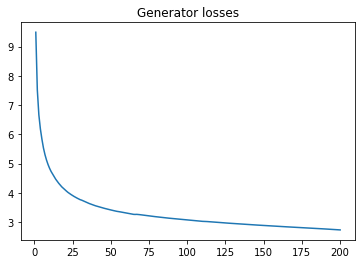

In [ ]:
# line 1 points
x1 = range(1,n+1)
y1 = G_l
# plotting the line 1 points 
plt.plot(x1, y1, label = "Generator losse")

plt.title('Generator losses')



Text(0.5, 1.0, 'Descriminator losses')

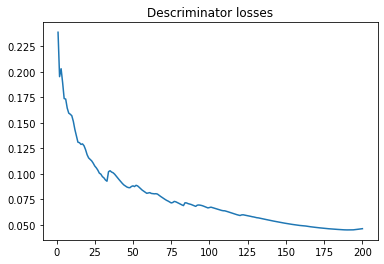

In [ ]:
# line 2 points
x2 = range(1,n+1)
y2 = D_l
# plotting the line 2 points 
plt.plot(x2, y2, label = "Descriminator losse")

plt.title('Descriminator losses')


Text(0.5, 1.0, 'Reconstructor losses')

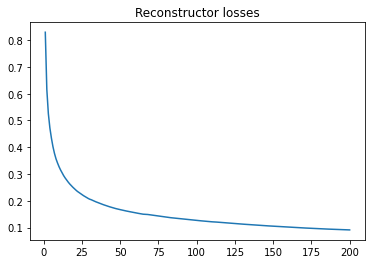

In [ ]:
# line 3 points
x3 = range(1,n+1)
y3 = R_l
# plotting the line 2 points 
plt.plot(x3, y3, label = "Reconstractor losse")
plt.title('Reconstructor losses')


#Testing losses

In [ ]:
#Recalculating testing losses
loss_G_A_B_f=[]
loss_G_B_A_f=[]
for i in range(0,12):
  real_image_A = opt['A_test'][i]
  real_image_B = opt['B_test'][i]
  synthetic_image_B = model['G_A2B'].predict(real_image_A[np.newaxis])[0]
  synthetic_image_A = model['G_B2A'].predict(real_image_B[np.newaxis])[0]
  loss_G_A_B=mse(real_image_A, synthetic_image_A)
  loss_G_A_B = mse(real_image_A,synthetic_image_A).eval(session=tf.compat.v1.Session())
  loss_G_A_B_f=np.append(loss_G_A_B_f,loss_G_A_B)
  loss_G_B_A=mse(real_image_B, synthetic_image_B)
  loss_G_B_A = mse(real_image_B,synthetic_image_B).eval(session=tf.compat.v1.Session())
  loss_G_B_A_f=np.append(loss_G_B_A_f,loss_G_B_A)
  #print("B to A loss for iteration ",i)
  #print(loss)
  reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
  reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

In [ ]:

import pandas as pd
df = pd.DataFrame({'A_B loss':loss_G_A_B_f, 'B_A loss':loss_G_B_A_f})

In [ ]:
df

,A_B loss,B_A loss
0,0.065613,0.027091
1,0.054005,0.093056
2,0.083687,0.074820
3,0.086993,0.082370
4,0.032669,0.047623
5,0.064172,0.043511
6,0.062847,0.161598
7,0.148354,0.091370
8,0.184661,0.306095
9,0.179468,0.060829
